In [ ]:
#Important Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#Metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc

#Data Encoding
from sklearn.preprocessing import  OneHotEncoder

#Preprocessing
from sklearn.preprocessing import StandardScaler

#Classifier
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
#Synthetic dataset
synth_train = pd.read_csv('/content/drive/MyDrive/Degree Project/train3.zip', delimiter=',')
synth_test = pd.read_csv('/content/drive/MyDrive/Degree Project/test3.zip', delimiter=',')
def data(df1,df2):
  Y1 = df1['Label'].to_numpy()                            #Labels
  Y2 = df1['Label'].to_numpy()
  X1 = df1.to_numpy()
  X2 = df2.to_numpy()
  n  = X1.shape[0]
  X = np.concatenate((X1,X2),axis=0)
  X = np.delete(X, -1, axis=1)
  X1 = X[:,[0,1,3,5]]                                    #Categorical Features
  X2 = X[:, [2,4,6]]                                     #Numerical Features
  X1 = OneHotEncoder().fit_transform(X1).toarray() #Encode categorical features
  X = np.concatenate((X1,X2), axis=1)
  X = StandardScaler().fit_transform(X)            #Standardizes data
  X = np.asarray(X).astype('float32')
  Y1 = np.asarray(Y1).astype('float32')
  Y2 = np.asarray(Y1).astype('float32')
  X1 = X[0:n]
  X2 = X[0:n]
  return X1,X2,Y1,Y2
X_train,X_test,Y_train,Y_test = data(synth_train,synth_test)


In [ ]:
#KDD-Cup 99 dataset
KDD_train = pd.read_csv('/content/drive/MyDrive/Degree Project/kddcup.data_10_percent.gz', compression='gzip').dropna() 
KDD_test = pd.read_csv('/content/drive/MyDrive/Degree Project/corrected.gz', compression='gzip').dropna()
KDD_train.columns = [
    'duration',
    'protocol_type',
    'service',
    'flag',
    'src_bytes',
    'dst_bytes',
    'land',
    'wrong_fragment',
    'urgent',
    'hot',
    'num_failed_logins',
    'logged_in',
    'num_compromised',
    'root_shell',
    'su_attempted',
    'num_root',
    'num_file_creations',
    'num_shells',
    'num_access_files',
    'num_outbound_cmds',
    'is_host_login',
    'is_guest_login',
    'count',
    'srv_count',
    'serror_rate',
    'srv_serror_rate',
    'rerror_rate',
    'srv_rerror_rate',
    'same_srv_rate',
    'diff_srv_rate',
    'srv_diff_host_rate',
    'dst_host_count',
    'dst_host_srv_count',
    'dst_host_same_srv_rate',
    'dst_host_diff_srv_rate',
    'dst_host_same_src_port_rate',
    'dst_host_srv_diff_host_rate',
    'dst_host_serror_rate',
    'dst_host_srv_serror_rate',
    'dst_host_rerror_rate',
    'dst_host_srv_rerror_rate',
    'outcome'
]

KDD_test.columns = KDD_train.columns
#Remove duplicates
KDD_train = KDD_train.drop_duplicates(keep=False)
KDD_test = KDD_test.drop_duplicates(keep=False)
#Change outcome to 0 if normal and 1 if anomalous
KDD_train['outcome'] = (KDD_train['outcome']!='normal.')*1
KDD_test['outcome'] = (KDD_test['outcome']!='normal.')*1
def data(df):
  X = df.to_numpy()
  Y = X[:,-1]
  X = np.delete(X, -1, axis=1)
  X1 = np.array([X[:,0]]).transpose()
  X2 = OneHotEncoder().fit_transform(X[:,1:2]).toarray()
  X3 = X[:,4:]
  X = np.concatenate((X1,X2,X3), axis=1)
  X = np.asarray(X).astype('float32')
  Y = np.asarray(Y).astype('float32')
  # min_val = np.min(X2)
  # max_val = np.max(X2)
  # X = (X - min_val) / (max_val - min_val)
  X = StandardScaler().fit_transform(X)
  normal_indx = np.where(Y==0)                      #Index of normal observations
  anomaly_indx = np.where(Y==1)                     #Index of anomalies
  X_normal  = X[normal_indx]
  X_anomaly = X[anomaly_indx]
  Y_normal  = Y[normal_indx]
  Y_anomaly = Y[anomaly_indx]
  return X,X_normal,X_anomaly,Y,Y_normal,Y_anomaly

X_train,X_normal_train,X_anomaly_train,Y_train,Y_normal_train,Y_anomaly_train = data(KDD_train)
X_test,X_normal_test,X_anomaly_test,Y_test,Y_normal_test,Y_anomaly_test       = data(KDD_test) 

In [ ]:
#Autoencoder for anomaly detection
class Autoencoder_Anomaly(keras.Model):
  def __init__(self, data_dim=34, latent_dim=12):
    super(Autoencoder_Anomaly, self).__init__()
    self.data_dim    = data_dim
    self.latent_dim  = latent_dim
    self.autoencoder = self.Autoencoder()
    self.autoencoder.compile(optimizer=keras.optimizers.Adam(learning_rate=10**-4), loss='mae')

  def Autoencoder(self):
    #Encoder
    encoder_input = keras.Input(self.data_dim)
    x = encoder_input
    Neurons = [32,26,18,self.latent_dim]
    for N in Neurons:
      x = layers.Dense(N, activation='relu')(x)
    encoder_output = x
    Encoder = keras.Model(encoder_input, encoder_output, name="Encoder")
    #Decoder
    decoder_input= keras.Input(Neurons[-1])
    x = decoder_input
    for N in Neurons[::-1]:
      x = layers.Dense(N, activation='relu')(x)
    decoder_output = layers.Dense(self.data_dim, activation='linear')(x)
    Decoder = keras.Model(decoder_input, decoder_output, name="decoder")
    #Connecting Encoder and Decoder to create the Autoencoder
    autoencoder_input = keras.Input(self.data_dim)
    encoded_data = Encoder(autoencoder_input)
    decoded_data = Decoder(encoded_data)
    return keras.Model(autoencoder_input, decoded_data, name="autoencoder")

  def train(self,X_train, X_val, epochs=50, batch_size=512):
    history = self.autoencoder.fit(X_train,X_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val,X_val))
    plt.figure()
    plt.plot(history.history["loss"], label="Training Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.legend()

  def score_samples(self,X):
    reconstructions = self.autoencoder.predict(X)
    train_loss = keras.losses.mae(reconstructions, X)
    return train_loss


In [2]:
A = [32, 26, 18, 12]
for i in A[::-1]:
  print(i)

12
18
26
32


Epoch 1/5
31250/31250 [==============================] - 104s 3ms/step - loss: 0.2832 - val_loss: 0.2737
Epoch 2/5
31250/31250 [==============================] - 104s 3ms/step - loss: 0.2735 - val_loss: 0.2734
Epoch 3/5
31250/31250 [==============================] - 88s 3ms/step - loss: 0.2734 - val_loss: 0.2734
Epoch 4/5
31250/31250 [==============================] - 86s 3ms/step - loss: 0.2734 - val_loss: 0.2734
Epoch 5/5
31250/31250 [==============================] - 102s 3ms/step - loss: 0.2734 - val_loss: 0.2733


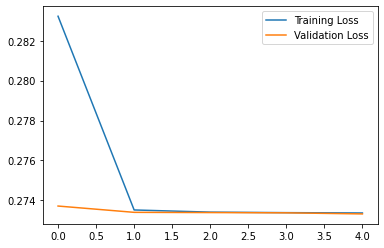

In [ ]:
Autoencoder = Autoencoder_Anomaly(data_dim=X_train.shape[1],latent_dim=10) #Creates a model-object
Autoencoder.train(X_train=X_train[0:10**6],X_val=X_test[0:10**6], epochs=5, batch_size=32) #Fit the model

In [ ]:
scores = Autoencoder.score_samples(X_test) #Score the test-samples

In [ ]:
#Evaluate scores
def evaluate(Y_real, scores, Dataset='Synthetic'):
  #Distribution of scores
  plt.figure()
  plt.hist(scores, bins=50)
  plt.xlabel("Anomaly score")
  plt.ylabel("No of examples")
  #plt.title('Distribution of anomaly scores')
  plt.show()
  #Precision-Recall curve
  precision, recall, thresholds = precision_recall_curve(Y_real, scores)
  auc_precision_recall = auc(recall, precision)
  indx = np.where(precision==0.)
  precision = np.delete(precision,indx)
  recall = np.delete(recall,indx)
  thresholds = np.delete(thresholds,indx)
  plt.figure()
  plt.plot(recall,precision)
  plt.xlabel("Recall")
  plt.ylabel("Precision")
  #plt.title(Dataset+' datset')
  plt.show()
  #Performance Scores
  F1_scores      = 2*precision*recall/(precision+recall)
  F1_max         = np.max(F1_scores)
  threshold_indx = np.where(F1_scores==F1_max) 
  y_pred = scores>=thresholds[threshold_indx]
  CM = confusion_matrix(Y_test,y_pred)

  TNR = CM[0,0] #True negative rate
  TPR = CM[1,1] #True positive rate
  FNR = CM[0,1] #False negative rate
  FPR = CM[1,0] #False positive rate

  #Table of performance metrics
  data = {'AUC_precision_recall': [auc_precision_recall], 'F1': [F1_max], 'TNR': [TNR], 'TPR': [TPR], 'FNR': [FNR], 'FPR': [FPR]}
  performance = pd.DataFrame(data, columns=['AUC_precision_recall', 'F1', 'TNR', 'TPR', 'FNR', 'FPR'], index=[Dataset])
  display(performance)
  return performance

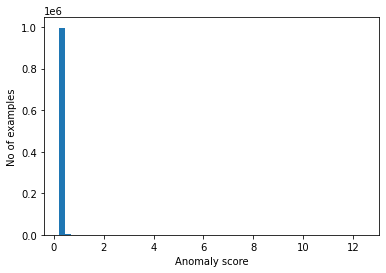

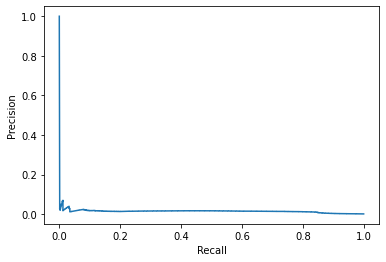

,AUC_precision_recall,F1,TNR,TPR,FNR,FPR
Synthetic,0.014123,0.036538,997472,61,2528,689


In [ ]:
table = evaluate(Y_test, scores)

In [ ]:
print(table.to_latex(index=True, multirow=True))

\begin{tabular}{lrrrrrr}
\toprule
{} &  AUC\_precision\_recall &        F1 &     TNR &  TPR &    FNR &  FPR \\
\midrule
Synthetic &              0.023901 &  0.057628 &  985751 &  445 &  14249 &  305 \\
\bottomrule
\end{tabular}

